[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/ml_intro/HEAD?labpath=notebooks%2F5_pytorch.ipynb)

# PyTorch

PyTorch is a machine learning framework that has two main features:
* Tensor computing (NumPy like) with GPU acceleration
* Deep neural networks with automatic differentiation

In [1]:
import torch

## GPU acceleration

If the GPU installation was successfully the following command should return `True`

In [2]:
torch.cuda.is_available()

True

If not, PyTorch can still be used on the CPU. We therefore select the device based on the availibility of the GPU.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

PyTorch can be used almost just like NumPy. The array-like objects are called tensors.

In [4]:
X = torch.tensor([1., 2., 3.])

In [5]:
X

tensor([1., 2., 3.])

In [6]:
B = torch.rand((5, 3))

In [7]:
B

tensor([[0.7221, 0.2921, 0.6770],
        [0.4339, 0.0329, 0.0685],
        [0.2924, 0.6438, 0.2479],
        [0.9333, 0.8219, 0.0985],
        [0.8478, 0.6455, 0.7207]])

Those tensors can be used for regular matrix arithmetics.

In [8]:
B @ X

tensor([3.3374, 0.7052, 2.3237, 2.8726, 4.3009])

Similar to NumPy, predefined functions can be applied to them.

In [9]:
torch.exp(X)

tensor([ 2.7183,  7.3891, 20.0855])

So far these computation have been on the CPU.

In [10]:
X.device, B.device

(device(type='cpu'), device(type='cpu'))

To use GPU acceleration, the tensors have to be sent to the respective device.

In [11]:
B = B.to(device)
X = X.to(device)

In [12]:
X.device, B.device

(device(type='cuda', index=0), device(type='cuda', index=0))

Computations involving these tensors now take place on the GPU.

In [13]:
B @ X

tensor([3.3374, 0.7052, 2.3237, 2.8726, 4.3009], device='cuda:0')

Tensors can be transfered to the cpu, for example for plotting.

In [14]:
Y = (B @ X).cpu()

In [15]:
Y

tensor([3.3374, 0.7052, 2.3237, 2.8726, 4.3009])

## Automatic differentiation

PyTorch uses gradient-based methods for optimizing the loss function. For this it has the capability of automatic differentiation of chained functions, which speeds up the computation tremendously.

In [16]:
def F(x):
    return torch.sin(x**2)

In [17]:
x = torch.linspace(-4., 4., 1000)

In [18]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

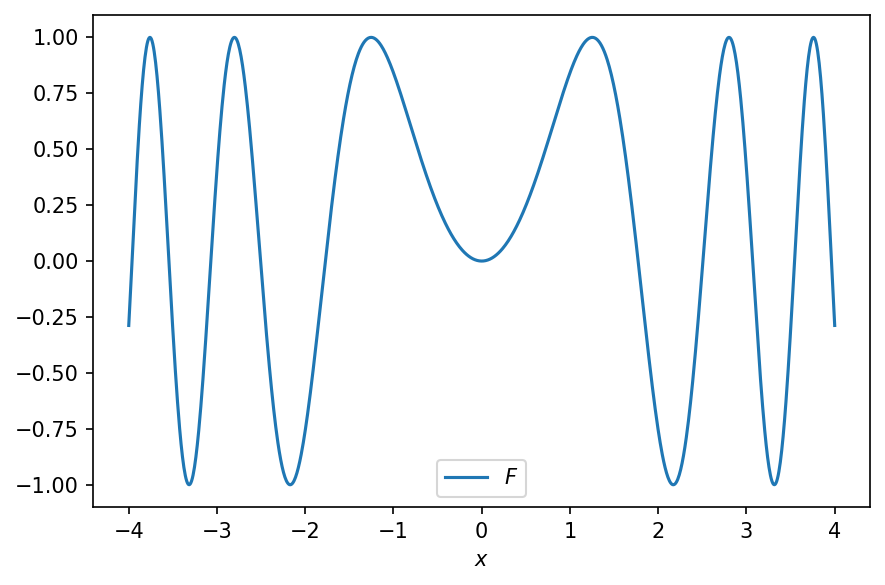

In [19]:
fig, ax = plt.subplots()
ax.plot(x.detach().numpy(), F(x).detach().numpy(), label="$F$")
ax.set_xlabel("$x$")
ax.legend()
fig.tight_layout()

Automatic differentiation only works on scalar outputs. Therefore we have to loop over the values.

In [20]:
dF = torch.empty_like(x)
for i, val in enumerate(x):
    val.requires_grad = True
    f = F(val)
    f.backward()
    dF[i] = val.grad

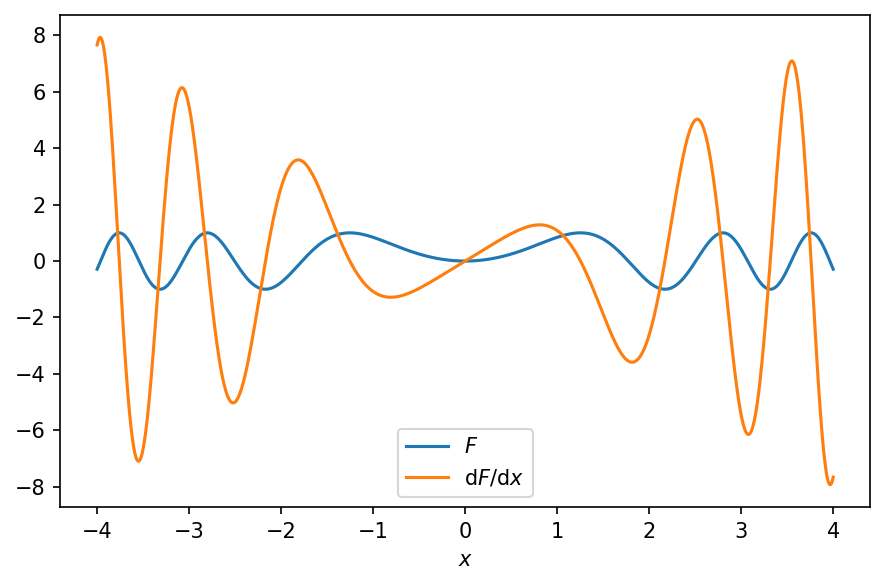

In [21]:
fig, ax = plt.subplots()
ax.plot(x.detach().numpy(), F(x).detach().numpy(), label="$F$")
ax.plot(x.detach().numpy(), dF, label="$\mathrm{d}F/\mathrm{d}x$")
ax.set_xlabel("$x$")
ax.legend()
fig.tight_layout()

## Optimization

PyTorch provides a couple of optimization algorithms typically used in machine learning, which can also be used in other context.  
Here we want to find the minimum of a custom function.

In [22]:
A, B, x0, y0 = 1., 0.2, 1., 2.

In [23]:
def func(X):
    x, y = X[..., 0], X[..., 1]
    return A*(x-x0)**2 + B*(y-y0)**2

In [24]:
Nx = 100
Ny = 200

In [25]:
import numpy as np

In [26]:
grid = np.mgrid[-4:4:Nx*1j, -4:4:Ny*1j]
X = np.swapaxes(grid, 0, -1).reshape(-1, 2)

In [27]:
F = func(X)

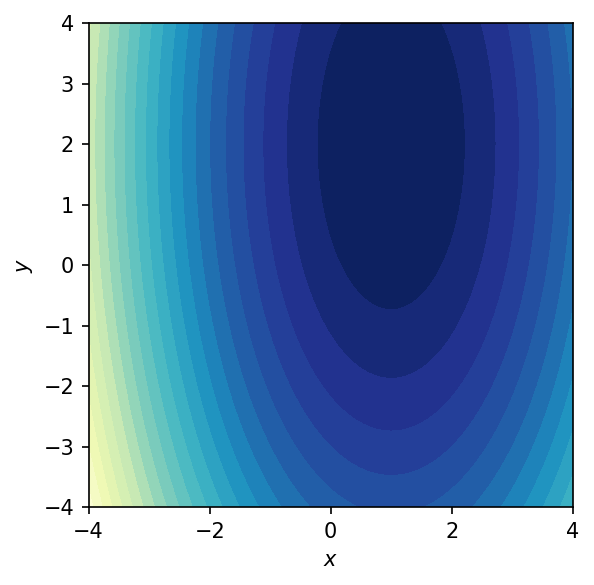

In [28]:
fig, ax = plt.subplots()
ax.set_aspect(1)
ax.contourf(grid[0, :, 0], grid[1, 0, :], F.reshape((Ny, Nx)), levels=30, cmap="YlGnBu_r")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
fig.tight_layout()

In [29]:
N_max = 20_000

In [30]:
def find_minimum(phi, func, optim, lr=1.e-3, weight_decay=0., eps=1.e-6, N_max=20_000):
    track = []
    phi = torch.tensor(phi, requires_grad=True)
    track.append(np.copy(phi.detach().numpy()))
    opt = optim([phi], lr=lr, weight_decay=weight_decay)
    for it in range(N_max):
        old = np.copy(phi.detach().numpy())
        Y = func(phi)
        Y.backward()
        opt.step()
        opt.zero_grad()
        track.append(np.copy(phi.detach().numpy()))
        if np.linalg.norm(old-phi.detach().numpy())<eps:
            break
    return np.array(track)

In [31]:
starts = [
    [-3., -3.],
    [ 1., -3.],
    [-3.,  3.],
]

In [32]:
from tqdm.auto import tqdm

In [33]:
learning_rate = 1.e-2
tracks = []
for s in tqdm(starts, desc="SGD"):
    t = find_minimum(s, func, torch.optim.SGD, lr=learning_rate)
    tracks.append(t)
tracks2 = []
for s in tqdm(starts, desc="Adam"):
    t = find_minimum(s, func, torch.optim.Adam, lr=learning_rate)
    tracks2.append(t)

SGD:   0%|          | 0/3 [00:00<?, ?it/s]

Adam:   0%|          | 0/3 [00:00<?, ?it/s]

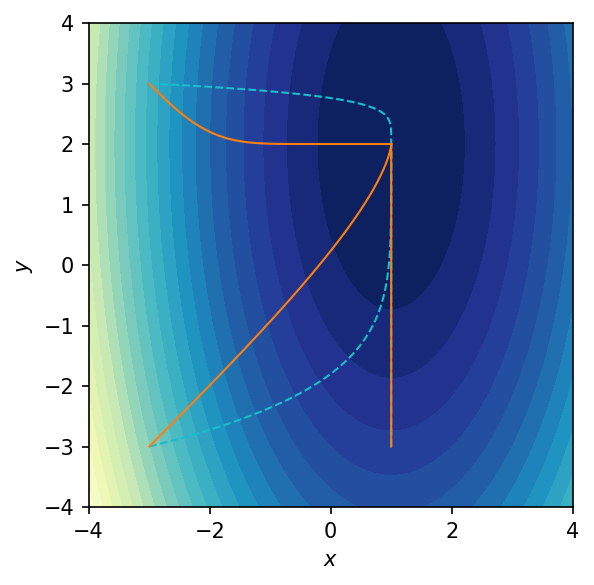

In [34]:
fig, ax = plt.subplots()
ax.set_aspect(1)
ax.contourf(grid[0, :, 0], grid[1, 0, :], F.reshape((Ny, Nx)), levels=30, cmap="YlGnBu_r")
for t in tracks:
    ax.plot(t[:, 0], t[:, 1], c="C9", lw=1, ls="--")
for t in tracks2:
    ax.plot(t[:, 0], t[:, 1], c="C1", lw=1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
fig.tight_layout()

In [35]:
print("Number of iterations\n")
print(f"{'Starting point':14}   {'SDG':>5}   {'Adam':>5}")
for i in range(len(starts)):
    print(f"{str(starts[i]):>14}   {len(tracks[i]):5}   {len(tracks2[i]):5}")

Number of iterations

Starting point     SDG    Adam
  [-3.0, -3.0]    2470    1908
   [1.0, -3.0]    2470    1908
   [-3.0, 3.0]    2054    1557


Sometimes it can be useful to adjust the learning rate during learning. PyTorch has learning rate scheduler for this purpose which modify the learning rate according a pre-defined function.

In [36]:
opt = torch.optim.SGD([torch.zeros(1)], lr=1.)
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, last_epoch=-1)

In [37]:
learning_rates = []
learning_rates.append(sched.get_last_lr()[0])
for i in range(500):
    opt.step()
    sched.step()
    current_lr = sched.get_last_lr()[0]
    learning_rates.append(current_lr)

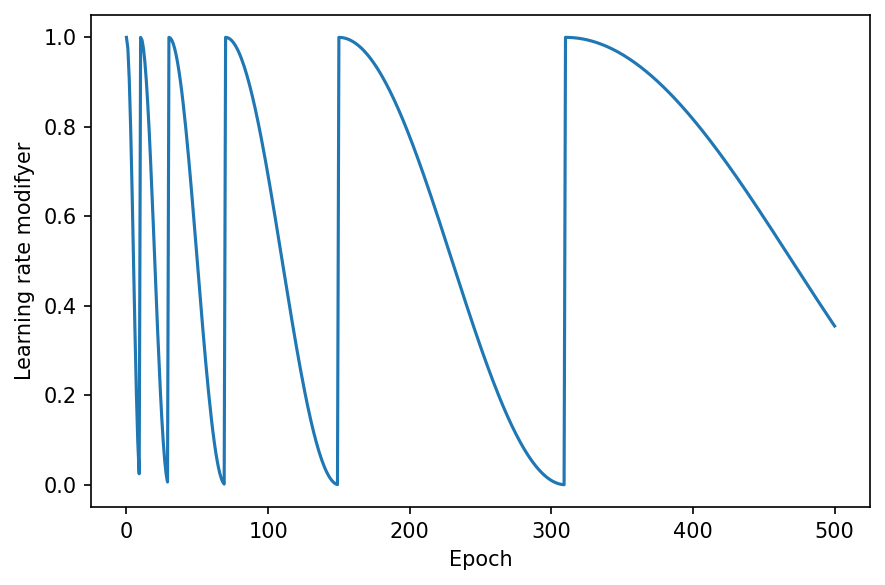

In [38]:
fig, ax = plt.subplots()
ax.plot(learning_rates)
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning rate modifyer")
fig.tight_layout()